# Classify costumers using Machine Learning methods
In this computer assignment, we implement a Decision Tree, K Nearest Neighbors, Ensemble methods to classify users whether *Is Back* is True or False.

#### Libraries
1. `pd` is imported to read dataset.

2. `metrics` is imported to calculate accuracy.

3. `LogisticRegression`, `RandomForestClassifier`, `KNeighborsClassifier`, `DecisionTreeClassifier` and `BaggingClassifier` are imported to build models for our classification problem.

4. `OneHotEncoder`, `LabelEncoder` and `StandardScaler` are imported to preprocess given dataset.

In [1]:
# !pip3 install seaborn
# !pip3 install pydotplus
# !pip3 install scikit-learn
# !pip3 install -U scikit-learn

import pydotplus
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import Image 
from sklearn import preprocessing
from IPython.display import Markdown, display
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

## Data
There is a `data.csv` file including a list of customers with their information such as *Is Back*, *Country*, *Date*, *Total Price* and etc.

#### Phase 0

To training models, it's necessary to clean data dependeing on the model needs to train. The following steps are required:

1. Converting the raw data into useable one such as: season, month, weekend, day of week, day
2. Converting categorical data into numerical data using LabelEncoder or OneHotEncoder

>    **LabelEncoder** vs **OneHotEncoder**:   
>    LabelEncoder assigns a number between 0 to number of categories to each category, but OneHotEncoder assings a dimention to each category. The major drawback of LabelEncoder is that the assigned number are sequential but the categorical values doesn't have any order. The major pitfall of OneHotEncoder is that it needs a lot of space to store information.
    
3. **Scaling data to have the same effect especially for KNeighborsClassifier**

In [6]:
######################################## Categorical : Country, Is Back #########################################
############################ date : day, month, quarter, dayofweek, weekend, season #############################
##################### Discrete : "Country", "season", "month", "weekend", "dayofweek", "day" ####################
def preprocessing(data, LabelEncoder_col = None, OneHotEncoder_col = None, scale_col = None, date_attributes = None,
                    redundant_attributes = ["Unnamed: 0", "Customer ID"], target_attributes = "Is Back"):
    data = data.drop(columns=redundant_attributes)
    if date_attributes:
        data["Date"] = pd.to_datetime(data["Date"])
        for att in date_attributes:
            if att == "weekend":
                data[att] = np.where(data["Date"].dt.dayofweek.isin([5, 6]), 1, 0)
            elif att == "season":
                data[att] = getattr(data["Date"].dt, "month")//4
            else:
                data[att] = getattr(data["Date"].dt, att)
        data = data.drop(columns="Date")
    if LabelEncoder_col:
        for col in LabelEncoder_col:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    if OneHotEncoder_col:
        for col in OneHotEncoder_col:
            data = pd.concat([data, pd.get_dummies(data[col])], axis=1).drop(columns=[col])
#     data["Dec"] = data["month"] == 12
    if scale_col:
        if scale_col == "all":
            for col in data.columns:
                if col == target_attributes:
                    continue
                scaler = StandardScaler()
                data[col] = scaler.fit_transform(data[[col]])
        else:
            for col in scale_col:
                scaler = StandardScaler()
                data[col] = scaler.fit_transform(data[[col]])
                
    y = data["Is Back"]
    X = data.drop(columns="Is Back")
    
    return X, y

seed = 6
data = pd.read_csv("data.csv")
X, y = preprocessing(data, LabelEncoder_col=["Is Back", "Country"], scale_col=["Total Price"],
                     date_attributes=["season", "month", "weekend", "dayofweek", "day"], redundant_attributes=[])
display(X)

,Unnamed: 0,Customer ID,Total Quantity,Total Price,Country,Purchase Count,season,month,weekend,dayofweek,day
0,0,16995,-1,-0.044660,35,1,3,12,0,3,2
1,1,12552,85,-0.032135,18,19,2,10,0,0,31
2,2,13192,298,-0.030117,35,33,1,5,0,2,18
3,3,16934,399,-0.036562,35,62,2,10,1,6,16
4,4,14976,27,-0.033509,35,16,0,1,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...
4361,4361,15445,58,-0.026301,35,5,0,3,1,6,20
4362,4362,12371,582,-0.039326,32,62,2,10,0,1,11
4363,4363,17693,231,-0.030880,35,16,1,7,0,0,25
4364,4364,18232,57,-0.028590,35,8,1,5,0,3,26


Another important step is calculating Information Gain for each feature. " *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and **higher values mean higher dependency**.* " Therefore, month and season have the most important impact.

To find a correct result, it's important to specify which features are discrete. 


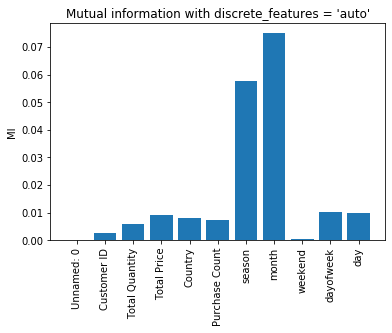

In [3]:
IG = mutual_info_classif(X, y, random_state=seed)
plt.bar(X.columns, IG)
plt.xticks(rotation='vertical')
plt.ylabel("MI")
plt.title("Mutual information with discrete_features = 'auto'")
plt.show()

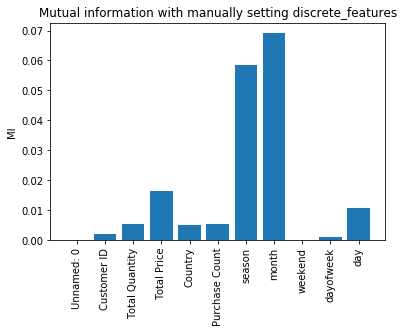

In [7]:
discrete_features_mask = np.where(X.columns.isin(["Country", "season", "month", "weekend", "dayofweek", "day"]), True, False)
IG = mutual_info_classif(X, y, discrete_features= discrete_features_mask, random_state=seed)
plt.bar(X.columns, IG)
plt.xticks(rotation='vertical')
plt.ylabel("MI")
plt.title("Mutual information with manually setting discrete_features")
plt.show()

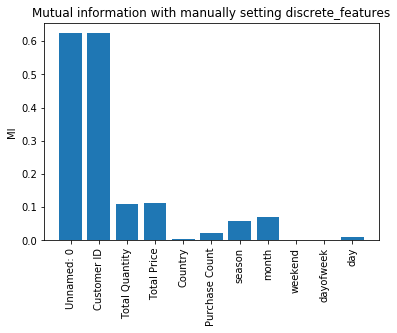

In [8]:
IG = mutual_info_classif(X, y, discrete_features= True, random_state=seed)
plt.bar(X.columns, IG)
plt.xticks(rotation='vertical')
plt.ylabel("MI")
plt.title("Mutual information with manually setting discrete_features")
plt.show()

It's important to discard "Customer ID" and "Unnamed: 0" because these two features have unique value which doesn't have any corrolation with target value, "Is Back", and `mutual_info_classif` removes them when discrete_features is set to 'auto'. 

## Phase 1

In the first step, it's necessary to **split** data into two random non-overlapping sets to train and validate our machine learning models.


In [9]:
def print_classification_metrics(acc, recall, precision, caption):
    string = "| Accuracy | Recall | Precision|\n" + "|:-:|:-:|:-:|\n"
    string = string + "| " + f"{acc:.3f}" +  "|" + f"{recall:.3f}" + "|" + f"{precision:.3f}" + "|\n"
    string = string + "<caption style=\"text-align:center\">" + caption + "</caption>\n"
    display(Markdown(string))
    
def evaluate(classifier, X, y, average_method="weighted"):
    y_pred = classifier.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred, average=average_method)
    precision = metrics.precision_score(y, y_pred, average=average_method)
    
    return acc, recall, precision

def evaluate_model(model, X_train, X_test, y_train, y_test, min_hyper, max_hyper, plot = True, seed = 5, max_sample = 0.5, min_samples_to_split = 10):
    hyper_arr = np.array([i for i in range(min_hyper, max_hyper)])
    acc_test = np.zeros(hyper_arr.shape)
    acc_train = np.zeros(hyper_arr.shape)
    recall_test = np.zeros(hyper_arr.shape)
    precision_test = np.zeros(hyper_arr.shape)
        
    for i, hyper in np.ndenumerate(hyper_arr):
        if model == "decision_tree":
            classifier = DecisionTreeClassifier(max_depth=hyper)
        elif model == "knn":
            classifier = KNeighborsClassifier(n_neighbors=hyper)
        elif model == "bagging_decision_tree":
            base_clf = DecisionTreeClassifier(max_depth = hyper)
            classifier = BaggingClassifier(base_estimator = base_clf, n_estimators = 55, max_samples = max_sample, max_features = 0.5, random_state = seed) 
        elif model == "bagging_knn":
            base_clf = KNeighborsClassifier(n_neighbors = hyper)
            classifier = BaggingClassifier(base_estimator = base_clf, n_estimators = 70, max_samples = max_sample, max_features = 0.5, random_state = seed) 
        elif model == "random_forest":
            classifier = RandomForestClassifier(max_depth=hyper, min_samples_split = min_samples_to_split, max_samples = max_sample, random_state = seed)
            
            
        classifier = classifier.fit(X_train,y_train)

        acc_test[i], recall_test[i], precision_test[i] = evaluate(classifier, X_test, y_test)
        acc_train[i], recall, precision = evaluate(classifier, X_train, y_train)


    best_index = np.argmax(acc_test)
    best_hyper = hyper_arr[best_index]
    best_acc = acc_test[best_index]
    best_recall = recall_test[best_index]
    best_precision = precision_test[best_index]
    
       
    if plot:
        plt.figure()
        plt.ylabel("Accuracy")
        plt.xlabel("Hyper parameter")
        if model == "random_forest":
            plt.title(model + " with max_sample = " + f"{min_samples_to_split:.0f}")
        else:
            plt.title(model)
        plt.plot(hyper_arr, acc_test, label='Test')
        plt.plot(hyper_arr, acc_train, label='Train')
        plt.legend()
        plt.show()
    
    return best_hyper, best_acc, best_recall, best_precision

def prepare_decision_tree_graph(max_depth = 3):
    classifier = DecisionTreeClassifier(max_depth=3)
    classifier = classifier.fit(X_train,y_train)
    out_file = tree.export_graphviz(classifier, feature_names = X_train.columns, class_names = ['[Is Back = No]', '[Is Back=Yes]'], filled = True, rounded = True)
    
    return pydotplus.graph_from_dot_data(out_file)

### 1.1 Split data into test and train
The first step is preprocessing data and spliting them into test and train.

In [10]:
data = pd.read_csv("data.csv")
X, y = preprocessing(data, OneHotEncoder_col= ["Country"], LabelEncoder_col=["Is Back"], scale_col= "all",
                     date_attributes=["season", "month", "weekend", "dayofweek", "day"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### Decision Tree
Using `DecisionTreeClassifier()` which is imported from `sklear.model` library, a model is trained for each diffrent `max_depth` in range \[2:10\]. The following figure shows the accuracy of train and test.

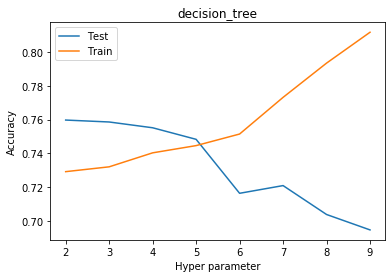

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.7597254004576659|0.7597254004576659|0.7518832333477643|
<caption style="text-align:center">Decision Tree with max_depth = 2</caption>


In [8]:
best_depth, best_acc, best_recall, best_precision = evaluate_model("decision_tree" , X_train, X_test, y_train, y_test, 2, 10)
print_classification_metrics(best_acc, best_recall, best_precision, "Decision Tree with max_depth = {}".format(best_depth))

**The above figure shows that increasing `max_depth` cause to overfit the Decision Tree**. And the following graph shows how decision tree interference works on our dataset:

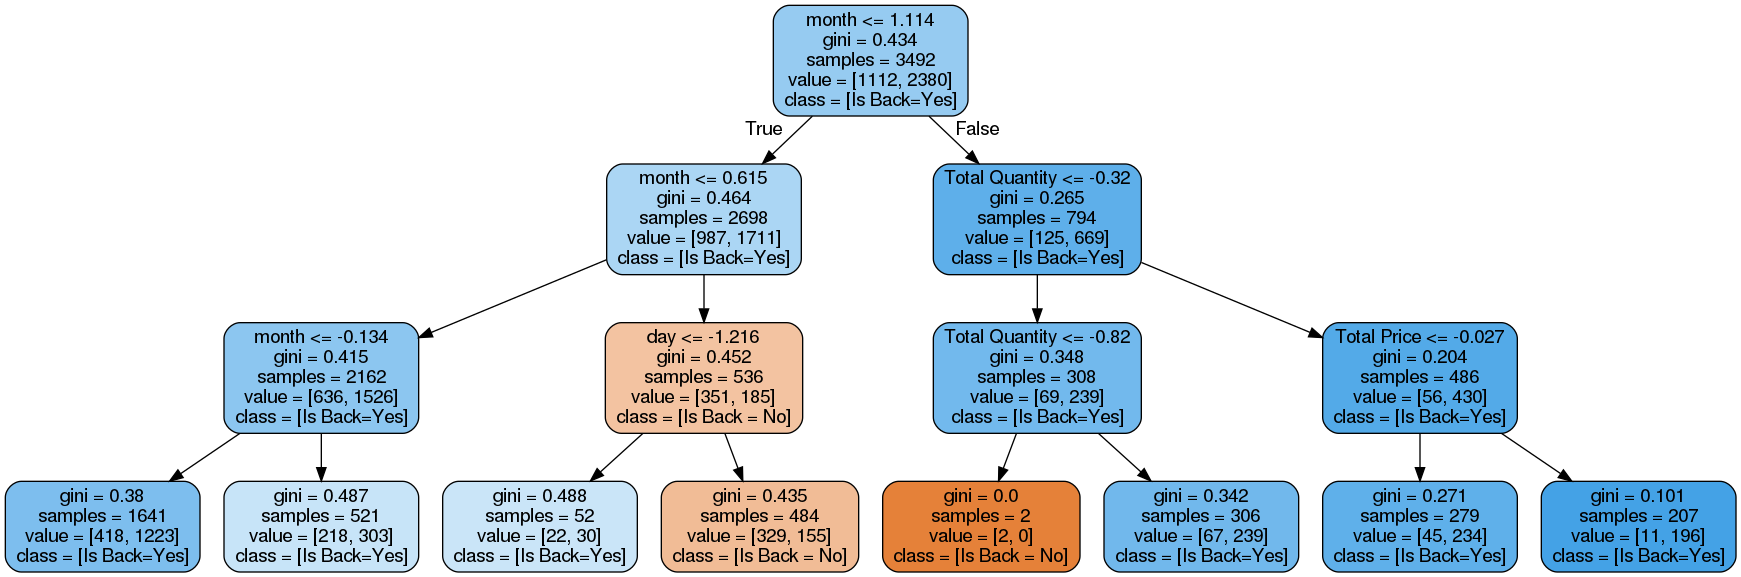

In [9]:
display(Image(prepare_decision_tree_graph().create_png()))

### KNN
Using `KNeighborsClassifier()` which is imported from `sklear.model` library, a model is trained for each diffrent `n_neighbors` in range \[15:35\]. The following figure shows the accuracy of train and test.

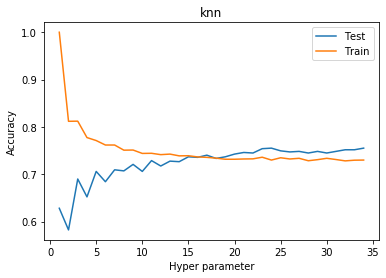

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.7551487414187643|0.7551487414187643|0.7417727561915011|
<caption style="text-align:center">KNN with n_neighbors = 24</caption>


In [10]:
best_k, best_acc, best_recall, best_precision = evaluate_model("knn", X_train, X_test, y_train, y_test, 1, 35)
print_classification_metrics(best_acc, best_recall, best_precision, "KNN with n_neighbors = {}".format(best_k))

### Logistic Classifier
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable.

In [11]:
classifier = LogisticRegression().fit(X_train,y_train)
acc, recall, precision = evaluate(classifier, X_test, y_test)
print_classification_metrics(acc, recall, precision, "Logistic Classifier")    

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.7208237986270023|0.7208237986270023|0.698366621936416|
<caption style="text-align:center">Logistic Classifier</caption>


### 1.4 Preprocessing used for Classifiers
For all three classifier, I used the same preprocessing. Each categorical variable is encoded with OneHotEncoder. Date is converted to "season", "month", "weekend", "dayofweek", "day". All variables are scaled to have zero mean and one variance.

## Phase 2
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

### 2.1 Bagging
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions to form a final prediction. 

The following figure shows that the trained bagging classifier with decision tree as a base classifier has not much better accuracy in compare with a decision tree. But the bagging classifier has better precision.

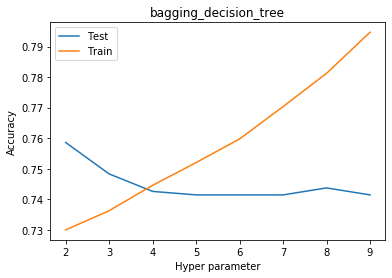

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.7585812356979404|0.7585812356979404|0.753392529705142|
<caption style="text-align:center">Bagging Decision Tree with max_depth  = 2</caption>


In [37]:
_, best_acc, best_recall, best_precision = evaluate_model("bagging_decision_tree", X_train, X_test, y_train, y_test, 2, 10)
print_classification_metrics(best_acc, best_recall, best_precision, "Bagging Decision Tree with max_depth  = {}".format(best_depth))

The following figure shows that the Bagging model doesn't increase classification accuracy.

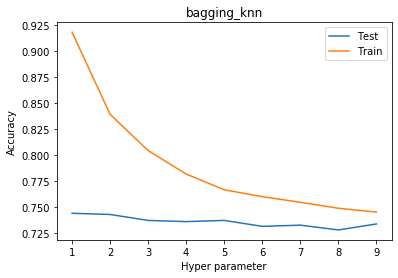

In [41]:
_ = evaluate_model("bagging_knn", X_train, X_test, y_train, y_test, 1, 10)

In [43]:
_, best_acc, best_recall, best_precision = evaluate_model("bagging_knn", X_train, X_test, y_train, y_test, best_k, best_k+1, plot=False)
print_classification_metrics(best_acc, best_recall, best_precision, "Bagging Decision Tree with max_depth  = {}".format(best_depth))

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.7299771167048055|0.7299771167048055|0.737102737741001|
<caption style="text-align:center">Bagging Decision Tree with max_depth  = 24</caption>


### 2.2 Random Forest

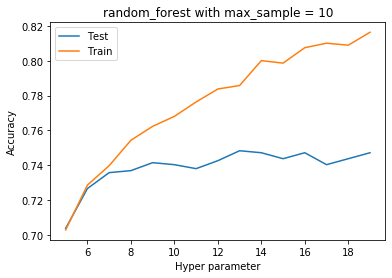

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.748|0.748|0.735|
<caption style="text-align:center">random_forest with max_depth = 13 and min_samples_split = 10</caption>


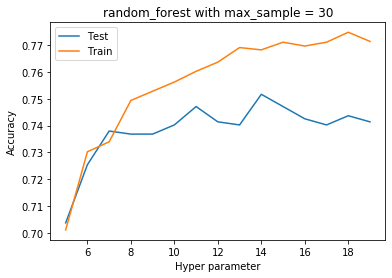

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.752|0.752|0.740|
<caption style="text-align:center">random_forest with max_depth = 14 and min_samples_split = 30</caption>


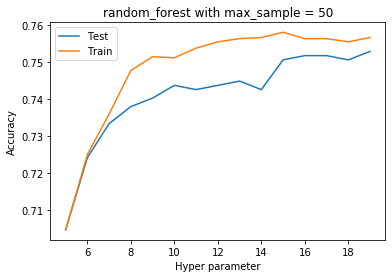

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.753|0.753|0.741|
<caption style="text-align:center">random_forest with max_depth = 19 and min_samples_split = 50</caption>


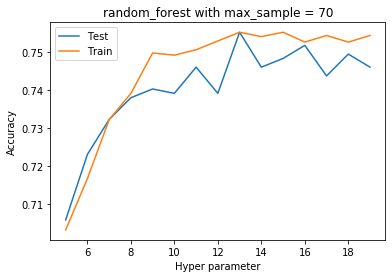

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.755|0.755|0.745|
<caption style="text-align:center">random_forest with max_depth = 13 and min_samples_split = 70</caption>


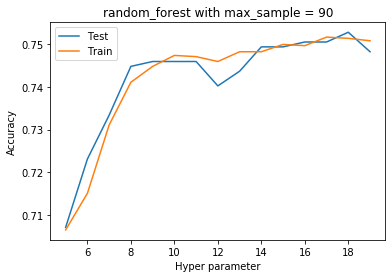

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.753|0.753|0.742|
<caption style="text-align:center">random_forest with max_depth = 18 and min_samples_split = 90</caption>


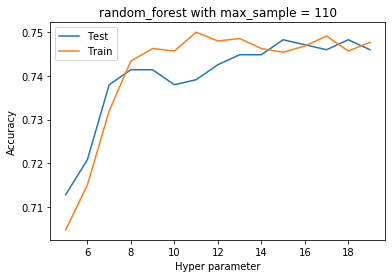

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.748|0.748|0.736|
<caption style="text-align:center">random_forest with max_depth = 15 and min_samples_split = 110</caption>


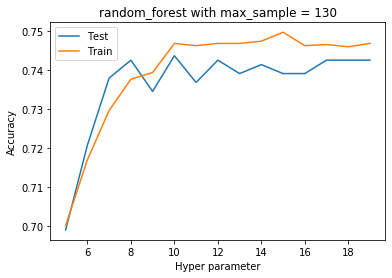

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.744|0.744|0.736|
<caption style="text-align:center">random_forest with max_depth = 10 and min_samples_split = 130</caption>


In [111]:
min_samples_split = [10*i for i in range(1, 14, 2)]
for i, ms in enumerate(min_samples_split):
    best_depth, best_acc, best_recall, best_precision = evaluate_model("random_forest", X_train, X_test, y_train, y_test, 5, 20, min_samples_to_split = ms)
    print_classification_metrics(best_acc, best_recall, best_precision, "random_forest with max_depth = {:.0f} and min_samples_split = {:.0f}".format(best_depth, ms))

Above figures show that the best max_depth and min_samples_split are 13 and 70. Increasing min_samples_split from 10 to 70, reduce overfitting and increase accuracy. Increasing min_samples_split from 70 to 130, increase underfitting and reduce accuracy.

### 2.3 Bagging and overfitting

According to the following figures, Bagging techniques has more robustness due to increasing the depth of trees. The accuracy of decision trees fell more than 10% in comparison with the bagging classifier.

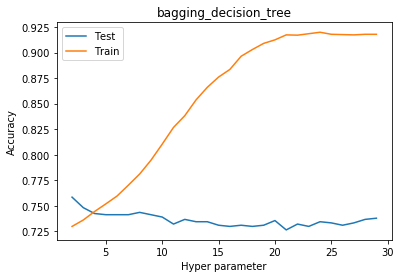

In [13]:
_ = evaluate_model("bagging_decision_tree", X_train, X_test, y_train, y_test, 2, 30)

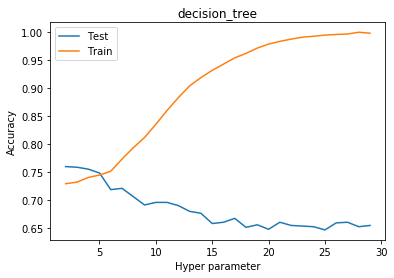

In [14]:
_ = evaluate_model("decision_tree", X_train, X_test, y_train, y_test, 2, 30)

### 2.4 Bootstrapping, variance and bias

"In statistics, Bootstrap Sampling is a method that involves drawing of sample data repeatedly with replacement from a data source to estimate a population parameter." Bootstrap sampling which is used in Bagging helps in avoiding overfitting and improves the stability of machine learning algorithms.

In other words, models like Decision trees have low bias and high variance training them probably leads to overfitting. Reducing variance needs to generalize the model prediction which is possible by building models using bootstrap.

### 2.5 Hard-Voting

The idea behind the Hard-Voting Classifier is to combine conceptually different machine learning classifiers and use a majority vote to predict the class labels.

In [21]:
clf1 = DecisionTreeClassifier(max_depth=2)
clf2 = KNeighborsClassifier(n_neighbors=24)
clf3 = LogisticRegression()
classifier = VotingClassifier(estimators=[('DT', clf1), ('KNN', clf2), ('LR', clf3)], voting='hard').fit(X_train, y_train)
best_acc, best_recall, best_precision = evaluate(classifier, X_test, y_test)
print_classification_metrics(best_acc, best_recall, best_precision, "Hard-Voting")

| Accuracy | Recall | Precision|
|:-:|:-:|:-:|
| 0.759|0.759|0.757|
<caption style="text-align:center">Hard-Voting</caption>


As we can, the performance metrics , generally, is increased due to using the Hard-Voting method.

### 2.6 Inefficiency of Ensemble Methods

The classifiers of the phase one are basic classifiers which would not consider wide range of features. Therefore, combining these simple calssifiers may not lead to a much accurate classifier.

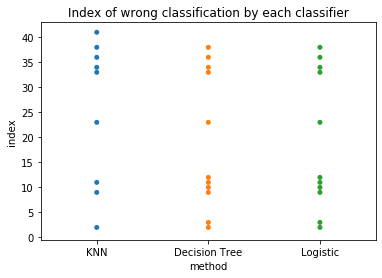

In [43]:
clf1 = DecisionTreeClassifier(max_depth=2)
clf2 = KNeighborsClassifier(n_neighbors=24)
clf3 = LogisticRegression()
classifier_voting = VotingClassifier(estimators=[('DT', clf1), ('KNN', clf2), ('LR', clf3)], voting='hard').fit(X_train, y_train)
y_pred_voting = classifier_voting.predict(X_test)

classifier_decision_tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
y_pred_decision_tree = classifier_decision_tree.predict(X_test)

classifier_KNeighbors = KNeighborsClassifier(n_neighbors=24).fit(X_train, y_train)
y_pred_KNeighbors = classifier_KNeighbors.predict(X_test)

classifier_LogisticRegression = LogisticRegression().fit(X_train, y_train)
y_pred_Logistic = classifier_LogisticRegression.predict(X_test)

df = pd.DataFrame(data = {"method": [], "index": []})

for i in range(50):
    if y_test.tolist()[i] != y_pred_KNeighbors.tolist()[i]:
        df = df.append({"method" : "KNN", "index" : i}, ignore_index=True)
    if y_test.tolist()[i] != y_pred_decision_tree.tolist()[i]:
        df = df.append({"method" : "Decision Tree", "index" : i}, ignore_index=True)
    if y_test.tolist()[i] != y_pred_Logistic.tolist()[i]:
        df = df.append({"method" : "Logistic", "index" : i}, ignore_index=True)

plt.title('Index of wrong classification by each classifier')
p = sb.stripplot(data=df, x='method', y='index', jitter=False)


Above figure verifies that the classifiers make mistakes like each other. 